# Super-Resolution 2D Deffusion Model Architecture MRI

SR3 - Super Resolution Diffusion via Iterative Refinement

## 1. Libraries

In [ ]:
!nvidia-smi

Mon May 26 16:32:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
from google.colab import drive
from keras import backend as k
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import keras
import math
import time
import os
import gc

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.backend.clear_session()

## 2. Managing Data

In [ ]:
path = '/content/drive/My Drive/Tesis/Data/'

In [ ]:
train_high_mri_load = np.load(f'{path}train_high_mri.npy')
train_low_mri_load = np.load(f'{path}train_low_mri.npy')

In [ ]:
print("Shape of test high mri:", train_high_mri_load.shape)
print("Shape of test low mri:", train_low_mri_load.shape)

Shape of test high mri: (25179, 256, 256, 1)
Shape of test low mri: (25179, 256, 256, 1)


In [ ]:
train_high_mri= train_high_mri_load[0:800]
train_low_mri= train_low_mri_load[0:800]
test_high_mri= train_high_mri_load[801:901]
test_low_mri= train_low_mri_load[801:901]

In [ ]:
print("Shape of training high mri:", train_high_mri.shape)
print("Shape of training low mri:", train_low_mri.shape)
print("Shape of test high mri:", test_high_mri.shape)
print("Shape of test low mri:", test_low_mri.shape)

Shape of training high mri: (800, 256, 256, 1)
Shape of training low mri: (800, 256, 256, 1)
Shape of test high mri: (100, 256, 256, 1)
Shape of test low mri: (100, 256, 256, 1)


## 3. Visualizing the Data

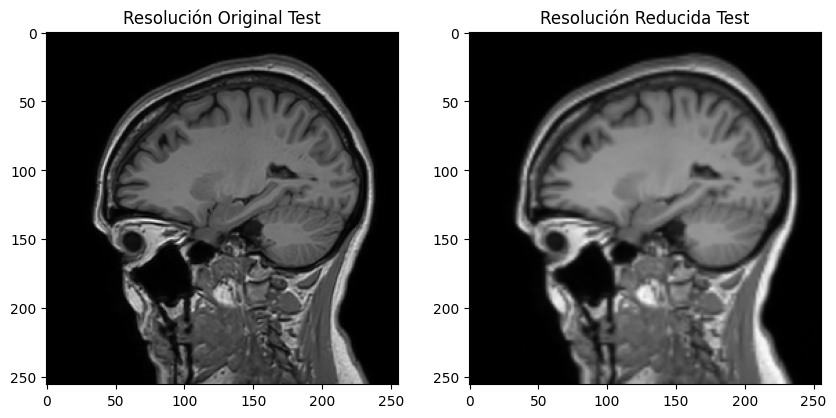

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_high_mri[20], cmap='gray')
plt.title('Resolución Original Test')
plt.subplot(1, 2, 2)
plt.imshow(test_low_mri[20], cmap='gray')
plt.title('Resolución Reducida Test')
plt.show()

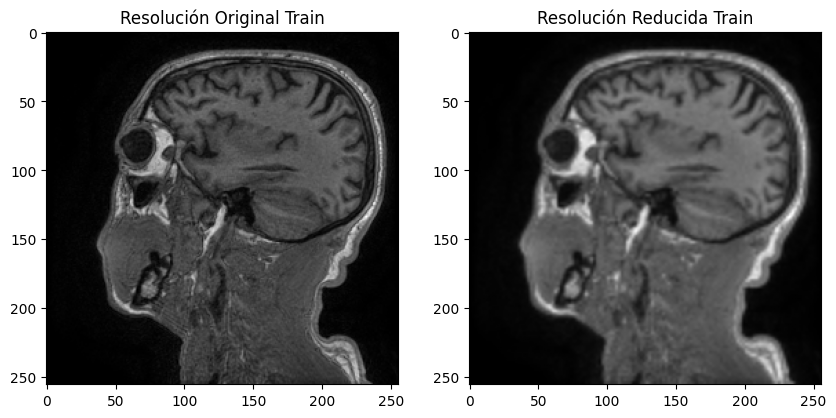

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_high_mri[250], cmap='gray')
plt.title('Resolución Original Train')
plt.subplot(1, 2, 2)
plt.imshow(train_low_mri[250], cmap='gray')
plt.title('Resolución Reducida Train')
plt.show()

## 4. Forward Diffusion Process

In [ ]:
TIMESTEPS = 500

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, TIMESTEPS)

alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

Funciones para agregar ruido progresivo

In [ ]:
# Agrega ruido a la imagen de entrada para cada marca de tiempo
def add_noise(img, t):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    noise = np.random.normal(size=img.shape).astype(np.float32)
    # Move noise to the GPU
    noise = tf.convert_to_tensor(noise, dtype=tf.float32)
    sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), [-1, 1, 1, 1])
    one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), [-1, 1, 1, 1])
    noisy_img = sqrt_alpha_bar_t  * img + one_minus_sqrt_alpha_bar_t  * noise
    #return tf.convert_to_tensor(noisy_img), tf.convert_to_tensor(noise)
    return noisy_img, noise

Visualización de la imagen degradada en algunas marcas de tiempo

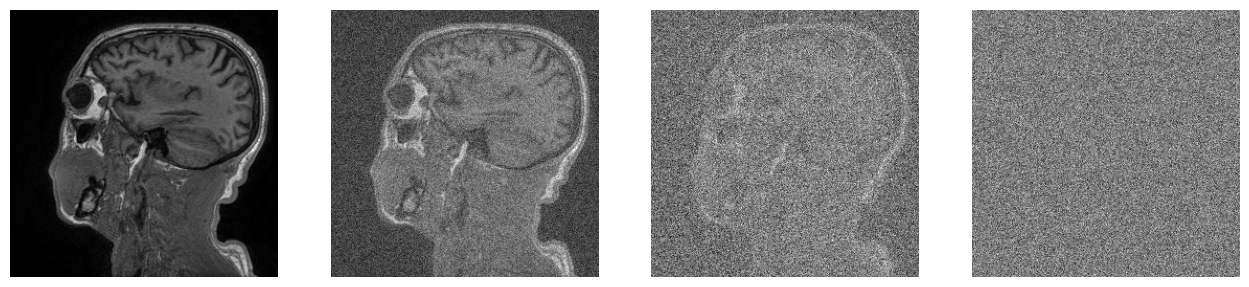

In [ ]:
img_sample = train_high_mri[250]

fig = plt.figure(figsize=(20, 30))
for index, i in enumerate([0,10,50,499]):
    noisy_im, noise = add_noise(img_sample, np.array([i,]))
    noisy_im = noisy_im[0]
    plt.subplot(1, 5, index+1)
    plt.axis('off')
    plt.imshow(noisy_im, cmap='gray')
    del noisy_im, noise
plt.show()

## 5. Defining the Model

SR Difussion Model - SR3

El modelo tiene una arquitectura U-Net.

In [ ]:
def block(x_img, x_ts, name):
    # Primera capa
    x_parameter = nn.Conv2D(64, kernel_size=3, padding='same')(x_img)
    x_parameter = nn.Activation('relu')(x_parameter)
    # Time parameter
    time_parameter = nn.Dense(64)(x_ts)
    time_parameter = nn.Activation('relu')(time_parameter)
    time_parameter = nn.Reshape((1, 1, 64))(time_parameter)
    x_parameter = x_parameter * time_parameter
    # Capa de salida
    x_out = nn.Conv2D(64, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = nn.LayerNormalization()(x_out)
    x_out = nn.Activation('relu', name=name)(x_out)
    return x_out

In [ ]:
IMG_SIZE = 256
def build_unet_model():
    # Definición de las entradas al modelo
    input_noisy = nn.Input(shape=(IMG_SIZE,IMG_SIZE,1), name='x_input_noisy') # input noisy image
    input_low = nn.Input(shape=(IMG_SIZE,IMG_SIZE,1), name='x_input_low')   # input bicubic upscaled image
    x = nn.Concatenate(axis=-1)([input_noisy,input_low])  # concatenate input noisy image and input bicubic upscaled image along the Channel axis
    # Entrada de la marca de tiempo
    input_ts = nn.Input(shape=(1,), name='x_input_ts')
    x_ts = nn.Dense(64)(input_ts)
    x_ts = nn.LayerNormalization()(x_ts)
    x_ts = nn.Activation('relu')(x_ts)
    # Down
    x = x256 = block(x, x_ts, 'down_1')
    x = nn.MaxPool2D(2)(x)
    x = x128 = block(x, x_ts, 'down_2')
    x = nn.MaxPool2D(2)(x)
    x = x64 = block(x, x_ts, 'down_3')
    x = nn.MaxPool2D(2)(x)
    x = x32 = block(x, x_ts, 'down_4')
    # MLP
    x = nn.Flatten()(x)
    x = nn.Concatenate()([x, x_ts])
    x = nn.Dense(64)(x)
    x = nn.LayerNormalization()(x)
    x = nn.Activation('relu')(x)
    x = nn.Dense(32*32*64,name="mlp_dense_2")(x)
    x = nn.LayerNormalization()(x)
    x = nn.Activation('relu')(x)
    x = nn.Reshape((32,32,64))(x)
    # Up
    x = nn.Concatenate()([x, x32])
    x = block(x, x_ts, 'up_1')
    x = nn.UpSampling2D(2)(x)
    x = nn.Concatenate()([x, x64])
    x = block(x, x_ts, 'up_2')
    x = nn.UpSampling2D(2)(x)
    x = nn.Concatenate()([x, x128])
    x = block(x, x_ts, 'up_3')
    x = nn.UpSampling2D(2)(x)
    x = nn.Concatenate()([x, x256])
    x = block(x, x_ts, 'up_4')
    # Output
    x = nn.Concatenate()([x, input_noisy, input_low])
    x = nn.Conv2D(1, kernel_size=1, padding='same')(x)
    return Model([input_noisy, input_low, input_ts], x)

In [ ]:
model = build_unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ x_input_ts          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        128 │ x_input_ts[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64)        │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_input_noisy       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ x_input_low         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64)        │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ x_input_noisy[0]… │
│ (Concatenate)       │ 2)                │            │ x_input_low[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,216 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64)        │          0 │ dense_1[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      1,216 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ activation_1[0][… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256,  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_1 (Activation) │ (None, 256, 256,  │          0 │ layer_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ down_1[0][0]    

 Total params: 9,438,467 (36.00 MB)

 Trainable params: 9,438,467 (36.00 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Compiling the Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

## 7. Training the Model

In [ ]:
checkpoint_dir = "/content/drive/My Drive/Tesis/SR3/diffusion_trained/"

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

history_list = []
num_images = len(train_high_mri)
t = np.arange(TIMESTEPS,-1,-1)

start_time = time.time()
for i in t[-TIMESTEPS:]:

    print('Timestep:', i)
    noisy_im, noise = add_noise(train_high_mri, np.array([i,]))
    time = tf.convert_to_tensor(np.repeat([i,], num_images))

    # Training
    history = model.fit([noisy_im, train_low_mri, time], noise, epochs=10, batch_size=64)
    history_list.append({'timestep': i, 'history': history.history})

    # Free memory
    del noisy_im, noise
    gc.collect()

    # Save Checkpoint
    if i % 100 == 0 or i in [50, 10, 1]:
        model.save(f"{checkpoint_dir}model_checkpoint_{i}.keras")
        np.save(f'{checkpoint_dir}history_list{i}.npy', history_list)
        print(f"Checkpoint guardado en timestep {i}.")
        tf.keras.backend.clear_session()
        gc.collect()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.2488e-05
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 5.8366e-05
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.1443e-05
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.9109e-05
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 5.9272e-05
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 5.6421e-05
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.1421e-05
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 5.9536e-05
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.0199e-05
Timestep: 236
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 7.2064e-05
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 7.7069e-05
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 6.1220e-05
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 6.3073e-05
Epoch 

In [ ]:
import time
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

Tiempo de entrenamiento: 13196.07 segundos


## 8. Evaluating the Model

In [ ]:
history_list = np.load(f'{checkpoint_dir}history_list0.npy', allow_pickle=True)

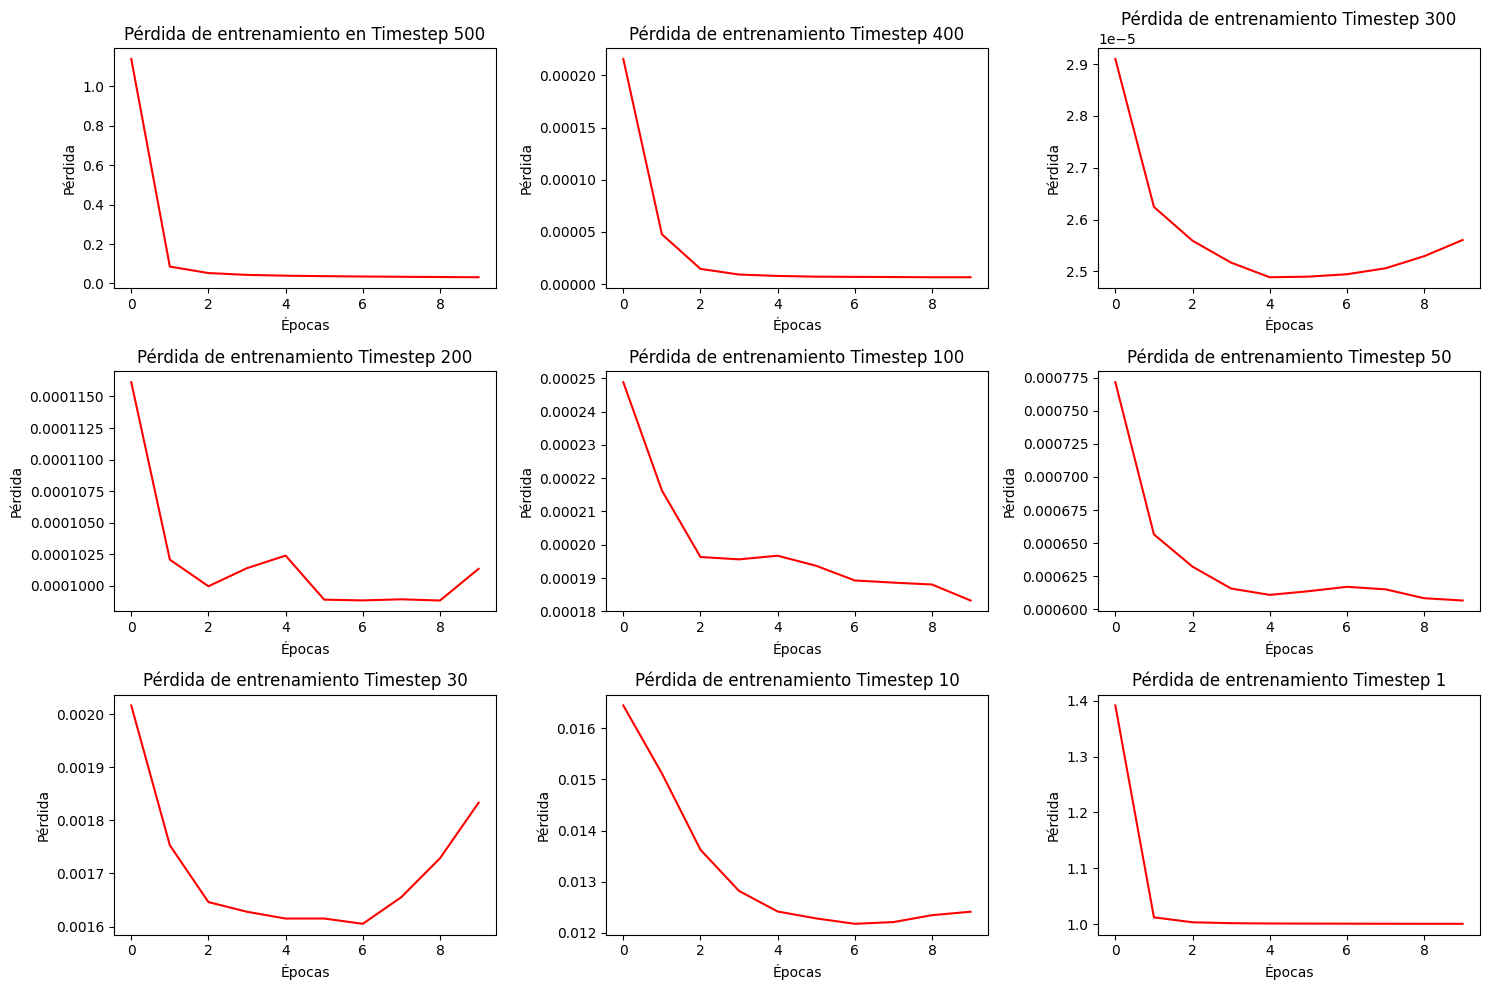

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Graficar la pérdida
axs[0,0].plot(history_list[0]['history']['loss'], 'r')
axs[0,0].set_title('Pérdida de entrenamiento en Timestep 500')
axs[0,0].set_xlabel('Épocas')
axs[0,0].set_ylabel('Pérdida')

axs[0,1].plot(history_list[101]['history']['loss'], 'r')
axs[0,1].set_title('Pérdida de entrenamiento Timestep 400')
axs[0,1].set_xlabel('Épocas')
axs[0,1].set_ylabel('Pérdida')

axs[0,2].plot(history_list[200]['history']['loss'], 'r')
axs[0,2].set_title('Pérdida de entrenamiento Timestep 300')
axs[0,2].set_xlabel('Épocas')
axs[0,2].set_ylabel('Pérdida')

axs[1,0].plot(history_list[300]['history']['loss'], 'r')
axs[1,0].set_title('Pérdida de entrenamiento Timestep 200')
axs[1,0].set_xlabel('Épocas')
axs[1,0].set_ylabel('Pérdida')

axs[1,1].plot(history_list[400]['history']['loss'], 'r')
axs[1,1].set_title('Pérdida de entrenamiento Timestep 100')
axs[1,1].set_xlabel('Épocas')
axs[1,1].set_ylabel('Pérdida')

axs[1,2].plot(history_list[450]['history']['loss'], 'r')
axs[1,2].set_title('Pérdida de entrenamiento Timestep 50')
axs[1,2].set_xlabel('Épocas')
axs[1,2].set_ylabel('Pérdida')

axs[2,0].plot(history_list[470]['history']['loss'], 'r')
axs[2,0].set_title('Pérdida de entrenamiento Timestep 30')
axs[2,0].set_xlabel('Épocas')
axs[2,0].set_ylabel('Pérdida')

axs[2,1].plot(history_list[490]['history']['loss'], 'r')
axs[2,1].set_title('Pérdida de entrenamiento Timestep 10')
axs[2,1].set_xlabel('Épocas')
axs[2,1].set_ylabel('Pérdida')

axs[2,2].plot(history_list[499]['history']['loss'], 'r')
axs[2,2].set_title('Pérdida de entrenamiento Timestep 1')
axs[2,2].set_xlabel('Épocas')
axs[2,2].set_ylabel('Pérdida')

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Tesis/SR3/train_sr3.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Denoising

In [ ]:
def ddim(x_t, pred_noise, t, step_size):
    alpha_t_bar = np.reshape(np.take(alpha_bar, t), [-1, 1, 1, 1])
    alpha_t_minus_one = np.reshape(np.take(alpha_bar, t-step_size), [-1, 1, 1, 1])

    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one) ** 0.5) * pred_noise
    return pred

## 10. Making Predictions

In [ ]:
# Genera 10 tensores de ruido aleatorio
x_1 = np.random.normal(size=(10, 256, 256, 1))
# Toma 10 imágenes MRI de baja resolución
high_mri_samples = test_high_mri[0:10]
low_mri_samples = test_low_mri[0:10]
# Imprime las formas de los tensores
print(x_1.shape)
print(high_mri_samples.shape)
print(low_mri_samples.shape)
#print(np.repeat(i,10).shape)

(10, 256, 256, 1)
(10, 256, 256, 1)
(10, 256, 256, 1)


In [ ]:
t = np.arange(TIMESTEPS,-1,-1)
checkpoints = [500, 400, 300, 200, 100, 50, 10, 1]

In [ ]:
model_trained_dir = "/content/drive/My Drive/Tesis/SR3/diffusion_trained/"
inf_step = 1
for k in range(len(checkpoints)):
    if checkpoints[k]==1:
        break
    print('Checkpoint: ', checkpoints[k+1])
    # Carga el modelo
    model_dir = os.path.join(model_trained_dir, f"model_checkpoint_{checkpoints[k+1]}.keras")
    print(model_dir)
    model = keras.models.load_model(model_dir)
    # Realiza predicciones de ruido para cada timestep
    for i in t[-checkpoints[k]:-checkpoints[k+1]]:
        print('Timestep: ',i)
        pred_noise = model.predict([x_1,low_mri_samples,np.repeat(i,10)],verbose=0)
        # Reconstruye la imagen por medio de Denoising
        x_1 = ddim(x_1, pred_noise, i, inf_step)
        if any(t-inf_step) == 0:
              break

Checkpoint:  400
/content/drive/My Drive/Tesis/SR3/diffusion_trained/model_checkpoint_400.keras
Timestep:  499
Timestep:  498
Timestep:  497
Timestep:  496
Timestep:  495
Timestep:  494
Timestep:  493
Timestep:  492
Timestep:  491
Timestep:  490
Timestep:  489
Timestep:  488
Timestep:  487
Timestep:  486
Timestep:  485
Timestep:  484
Timestep:  483
Timestep:  482
Timestep:  481
Timestep:  480
Timestep:  479
Timestep:  478
Timestep:  477
Timestep:  476
Timestep:  475
Timestep:  474
Timestep:  473
Timestep:  472
Timestep:  471
Timestep:  470
Timestep:  469
Timestep:  468
Timestep:  467
Timestep:  466
Timestep:  465
Timestep:  464
Timestep:  463
Timestep:  462
Timestep:  461
Timestep:  460
Timestep:  459
Timestep:  458
Timestep:  457
Timestep:  456
Timestep:  455
Timestep:  454
Timestep:  453
Timestep:  452
Timestep:  451
Timestep:  450
Timestep:  449
Timestep:  448
Timestep:  447
Timestep:  446
Timestep:  445
Timestep:  444
Timestep:  443
Timestep:  442
Timestep:  441
Timestep:  440
Time

In [ ]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    # Convert inputs to tf.float32 explicitly
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

def mse_metric(target, ref):
    mse_value = tf.square(target - ref)
    return tf.reduce_mean(mse_value)

def compare_images(real, pred):
    scores = []
    scores.append(i)
    scores.append(psnr_metric(real, pred).numpy())
    scores.append(ssim_metric(real, pred).numpy())
    scores.append(mse_metric(real, pred).numpy())
    print(scores)
    return scores

In [ ]:
def plot_images(high,low,predicted,i):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.subplot(1,3,2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.subplot(1,3,3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.savefig(f'/content/drive/My Drive/Tesis/SR3/result_sr3_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

[0, np.float32(53.317467), np.float32(0.99522686), np.float64(4.659090462560703e-06)]


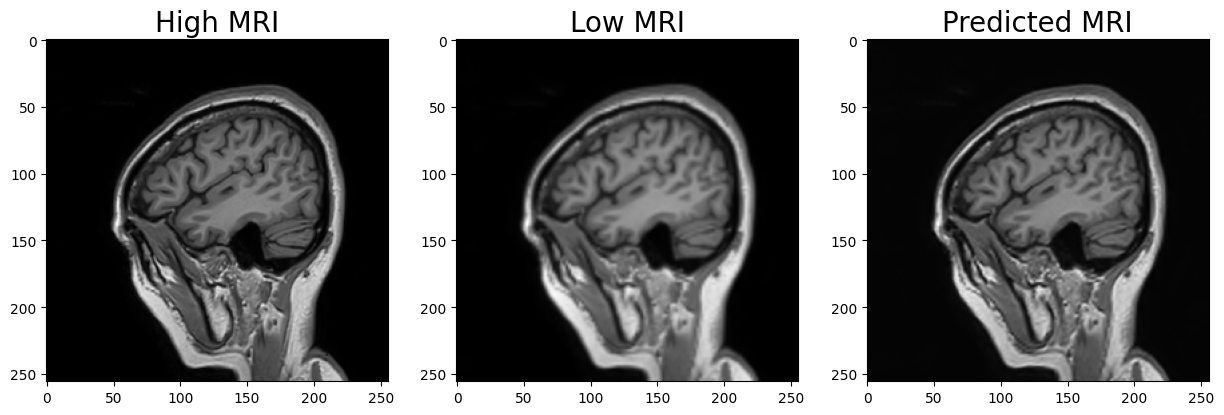

[1, np.float32(53.36792), np.float32(0.9952857), np.float64(4.605407690052633e-06)]


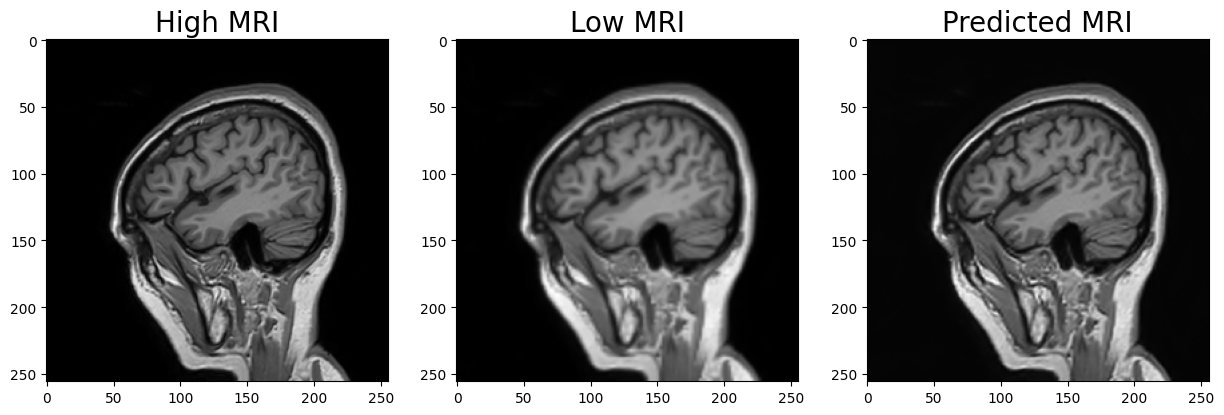

[2, np.float32(52.945263), np.float32(0.9950064), np.float64(5.076777614581654e-06)]


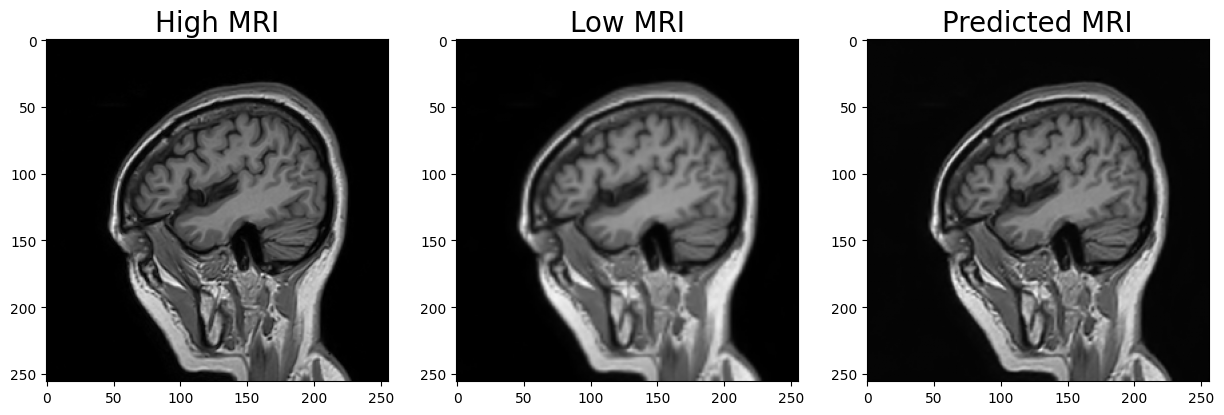

[3, np.float32(52.599174), np.float32(0.99475664), np.float64(5.497727186047018e-06)]


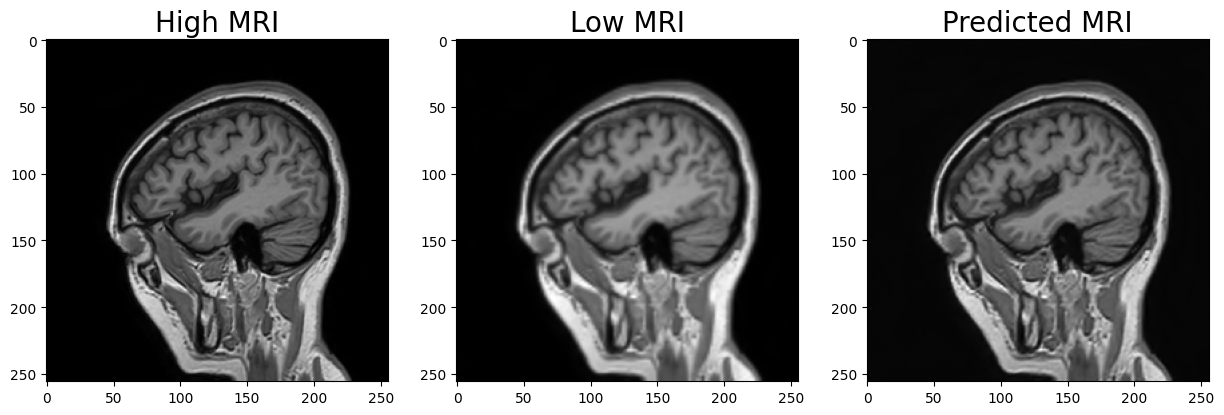

[4, np.float32(52.298927), np.float32(0.99444413), np.float64(5.891310314685215e-06)]


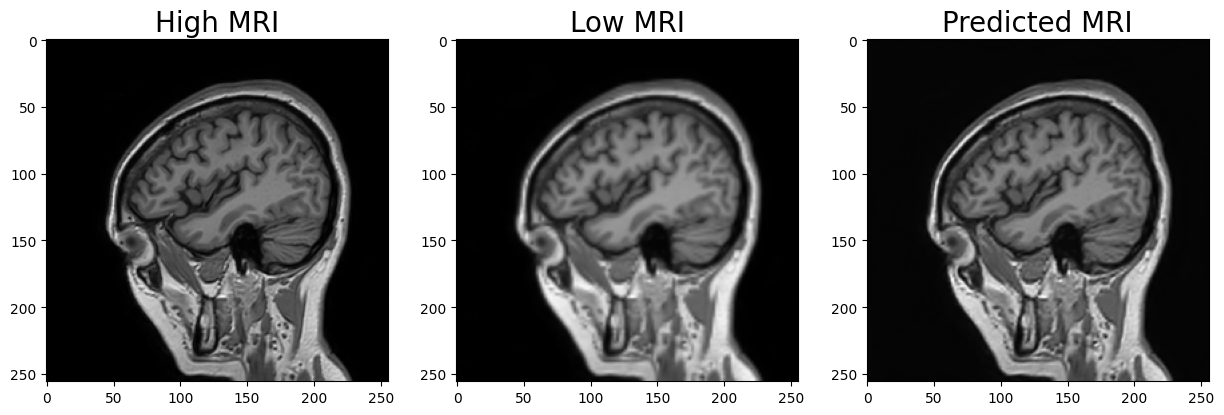

[5, np.float32(52.145344), np.float32(0.9943761), np.float64(6.103003651052817e-06)]


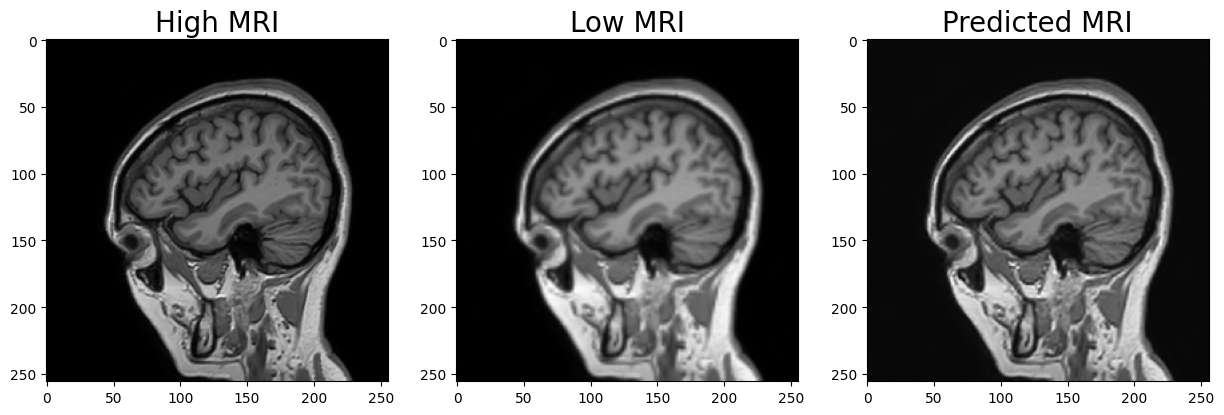

[6, np.float32(52.074703), np.float32(0.99435204), np.float64(6.2024754095361875e-06)]


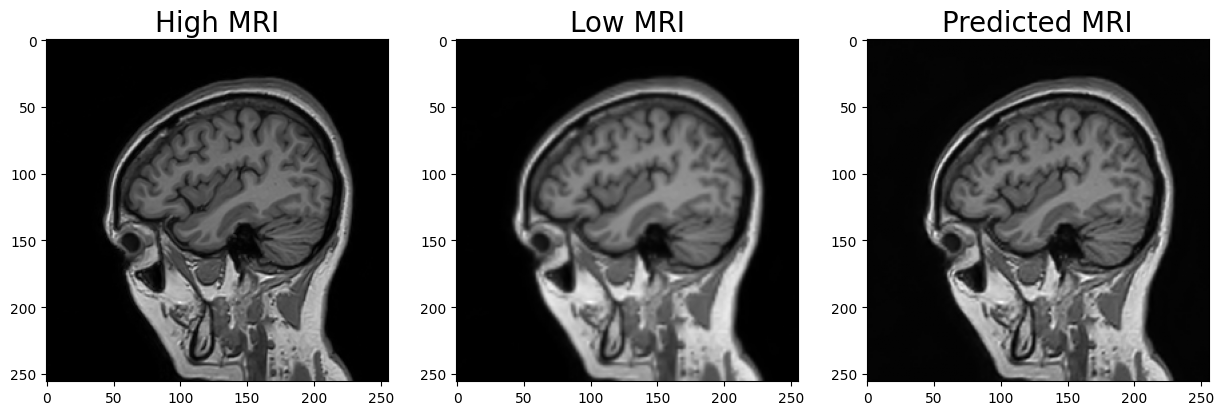

[7, np.float32(51.84745), np.float32(0.9942345), np.float64(6.536534097262129e-06)]


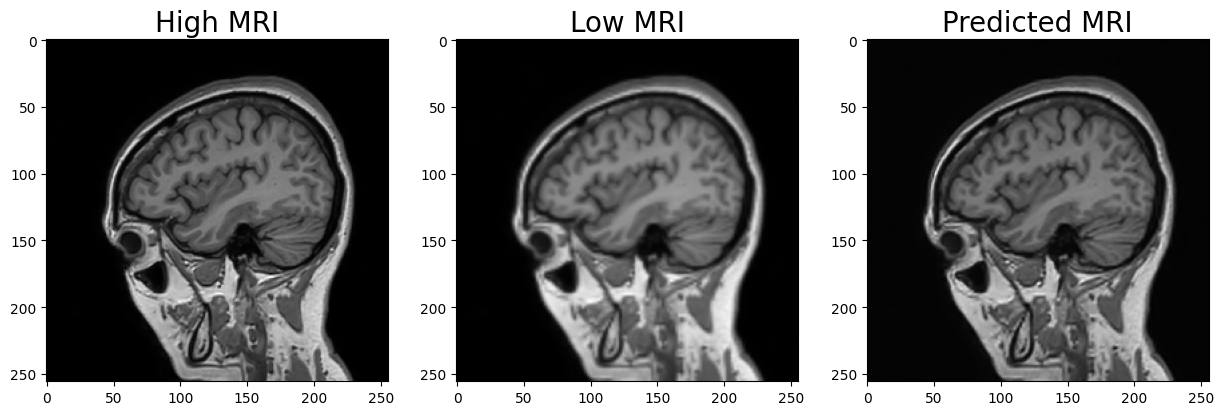

[8, np.float32(51.44405), np.float32(0.993683), np.float64(7.1732021552951e-06)]


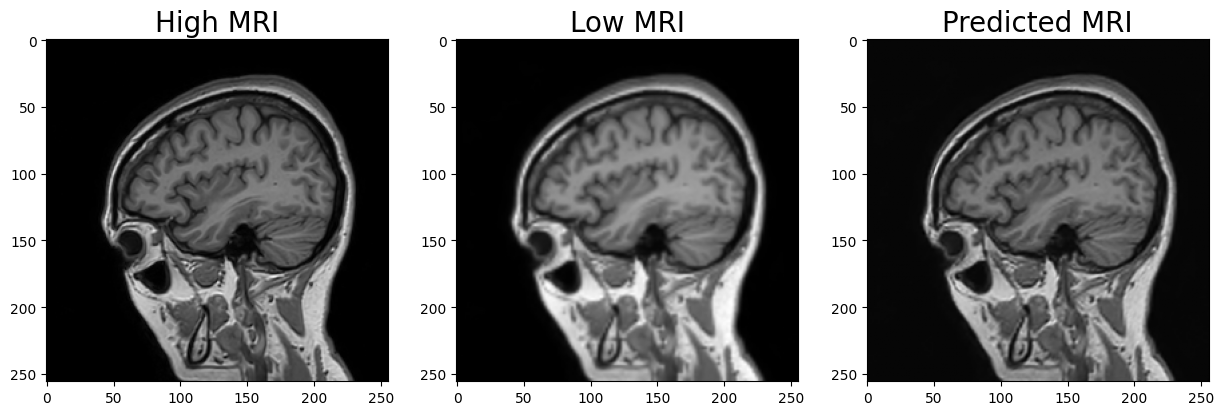

[9, np.float32(51.384567), np.float32(0.9937594), np.float64(7.2724542909509396e-06)]


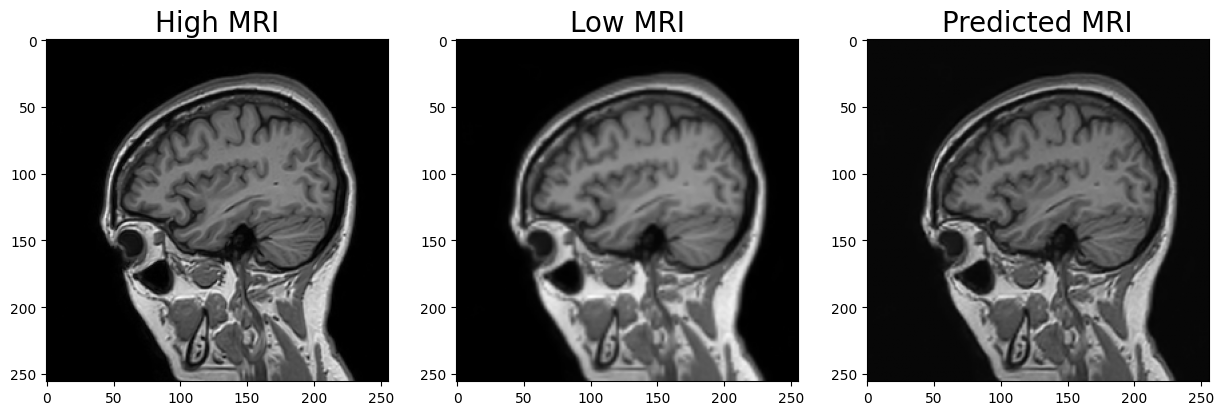

In [ ]:
scores = []
for i in range(10):
    #predicted = model.predict(test_low_mri[i].reshape(1,128,128,1))
    scores.append(compare_images(high_mri_samples[i], x_1[i]))
    plot_images(high_mri_samples[i],low_mri_samples[i],x_1[i],i)

In [ ]:
df_scores = pd.DataFrame(scores)
df_scores.columns = ['Item','PSNR','SSIM','MSE']
df_scores

Item       PSNR      SSIM       MSE
0     0  53.317467  0.995227  0.000005
1     1  53.367920  0.995286  0.000005
2     2  52.945263  0.995006  0.000005
3     3  52.599174  0.994757  0.000005
4     4  52.298927  0.994444  0.000006
5     5  52.145344  0.994376  0.000006
6     6  52.074703  0.994352  0.000006
7     7  51.847450  0.994235  0.000007
8     8  51.444050  0.993683  0.000007
9     9  51.384567  0.993759  0.000007